In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.sparse.linalg

# install this with "pip install datafold"
import datafold.pcfold as pfold

from large_eigensystems import *
from jointly_smooth_functions import JointlySmoothFunctions

In [2]:
# notebook parameters
n_pts = 2000
random_seed = 1
add = 0.2

verbose = True
n_kernel_normalizations = 3
evec_tol = 1e-10

n_kernel_evecs = 500
n_common_evecs = 10

cknn_k_neighbor = 50

cmap1 = "winter"
cmap2 = "bwr"
m_s = 5

idx_plot = np.arange(0,2000)

In [3]:
def sensor1(_x,_y, div = 3, mult = 4):
    return np.column_stack([
        _x,
        _y,
        #1/3*np.sin(2*np.pi*x)
    ])
    # return np.column_stack([
    #     2*(1+1/3*np.cos(np.pi*x))*np.cos(2*np.pi*z),
    #     (1+1/3*np.cos(np.pi*x))*np.sin(2*np.pi*z),
    #     #1/3*np.sin(2*np.pi*x)
    # ])
def sensor2(_x,_z, div = 5, mult = 6):
    return np.column_stack([
        (div/2*_z+_x/2+2/3)*np.cos(mult*np.pi*_z)/2,
        (div/2*_z+_x/2+2/3)*np.sin(mult*np.pi*_z)/2
    ])

def kernelmatrix(data, eps = None, sigma = 1e-5, cknn_k_neighbor=30, cknn_delta=1):
    #if eps is None:
    #    _pcm = pfold.PCManifold(data, dist_kwargs=dict(backend="guess_optimal"))
    #    _pcm.optimize_parameters(result_scaling=3)
    #else:
    #_k = pfold.kernels.GaussianKernel(epsilon=eps)
    _k = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)
    _pcm = pfold.PCManifold(data, kernel=_k, dist_kwargs=dict(backend="scipy.kdtree",cut_off=1e-16, kmin=cknn_k_neighbor*2))
    
    kernel_result,_ = _pcm.compute_kernel_matrix()
    
    res = scipy.sparse.csr_matrix(kernel_result, dtype=np.float64)
    
    res.eliminate_zeros()
    print(f"Sparsity of kernel: {res.count_nonzero() / res.shape[0]} neighbors per row")
    res = res @ scipy.sparse.diags(np.array(1/res.sum(axis=0)).ravel(), 0)
    
    return res

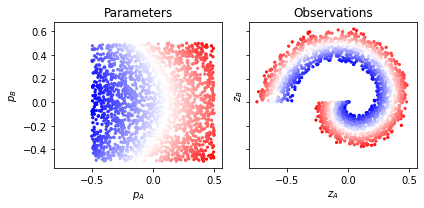

In [4]:
rng = np.random.default_rng(random_seed)

xyz = rng.uniform(low=-.5,high=.5,size=(n_pts,3))
x,y,z = xyz[:,0].reshape(-1,1), xyz[:,1].reshape(-1,1), xyz[:,2].reshape(-1,1)


s1 = sensor1(x,y,3,3)

omega = z[:,0]
peff = s1[:,0]+1*s1[:,1]**2

s2 = sensor2(peff,z[:,0],2,2)


fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

ax[0].scatter(*s1[:,[0,1]][idx_plot,:].T, s=m_s,c=peff[idx_plot,], cmap=cmap2)
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

ax[1].scatter(*s2[idx_plot,:].T, s=m_s,c=peff[idx_plot,], cmap=cmap2)
ax[1].set_title("Observations");
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()
#fig.savefig("jointly_smooth_idea_x1.png")

In [5]:
def _estimate_row_steps(data):
    """
    A good ballpack is to have roughly 100M entries at max.
    So for data with 100,000 points, 1000 rows per step is ok.
    """
    max_entries = int(100e6)
    return int(np.min([data.shape[0], max_entries // data.shape[0]]))

A_row_steps = _estimate_row_steps(s1)
print("Row steps", A_row_steps)

if False:
    k1 = KernelMatrixStored(s1, kernelstore_filename='kernel/kernel1',\
                               n_kernel_normalizations=n_kernel_normalizations,
                               verbose=verbose, has_kernel_stored=False, epsilon=eps1, row_steps=A_row_steps)
    k2 = KernelMatrixStored(s2, kernelstore_filename='kernel/kernel2',\
                               n_kernel_normalizations=n_kernel_normalizations,
                               verbose=verbose, has_kernel_stored=False, epsilon=eps2, row_steps=A_row_steps)
else:    
    k1 = kernelmatrix(s1, cknn_k_neighbor=cknn_k_neighbor, cknn_delta=1)
    k2 = kernelmatrix(s2, cknn_k_neighbor=cknn_k_neighbor, cknn_delta=1)

Row steps 2000


/home/ludwig/code/Python/spectral-discovery-of-jointly-smooth-features-for-multimodal-data/python/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Sparsity of kernel: 48.97 neighbors per row
Sparsity of kernel: 48.431 neighbors per row


/home/ludwig/code/Python/spectral-discovery-of-jointly-smooth-features-for-multimodal-data/python/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [6]:
#CE = CommonEigensystemMatrix(k1,k2, kernel_tol=1e-8, kernel_evecs=n_kernel_evecs, verbose=verbose, evec_tol=evec_tol)
#print(CE.shape)
#Cevecs,Cevals,_ = scipy.sparse.linalg.svds(CE.rows, k=n_common_evecs, which='LM', tol=evec_tol)
#Cevecs,Cevals,_ = scipy.linalg.svd(CE.rows)#, k=n_common_evecs, which='LM', tol=evec_tol)
#Cevals,Cevecs = CE._sort_eigensystem(Cevals, Cevecs)

#fig,ax=plt.subplots(1,1,figsize=(5,5))
#ax.plot(Cevals,'.-')

In [7]:
#n_plots = 6
#fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*3,3),sharey=True)
#for k in range(len(ax)):
#    ax[k].scatter(peff[idx_plot,].ravel(), Cevecs[idx_plot,k],c=xyz[idx_plot,0], s=5)
#    
#fig,ax=plt.subplots(1,2,figsize=(6,3),sharey=True, sharex=True)
#ax[0].scatter(*s1[idx_plot,:].T,c=Cevecs[idx_plot,0], s=m_s, cmap=cmap2);
#ax[1].scatter(*s2[idx_plot,:].T,c=Cevecs[idx_plot,0], s=m_s, cmap=cmap2);

/home/ludwig/code/Python/spectral-discovery-of-jointly-smooth-features-for-multimodal-data/python/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/ludwig/code/Python/spectral-discovery-of-jointly-smooth-features-for-multimodal-data/python/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


6.403639811725351
16.40363981172535


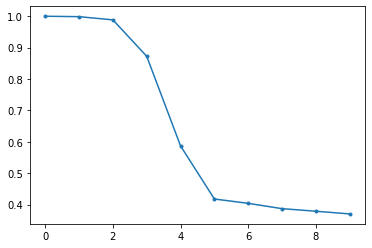

In [8]:
cknn_delta = 1
n_common_evecs = 10
n_kernel_evecs = 100
kernel_tolerance = 1e-8
eigenvector_tolerance = 1e-10
kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)

jsf = JointlySmoothFunctions(n_kernel_evecs, n_common_evecs, kernel, kernel_tolerance, 
                             evec_tol, backend='scipy.kdtree', cut_off=1e-16,)
jsf.fit(np.column_stack([s1, s2]), ending_points=[s1.shape[1], s1.shape[1]+s2.shape[1]])


plt.plot(jsf.eigenvalues,'.-')
print(jsf.eigenvalues.sum())
print(jsf.calculate_truncated_energies().sum())

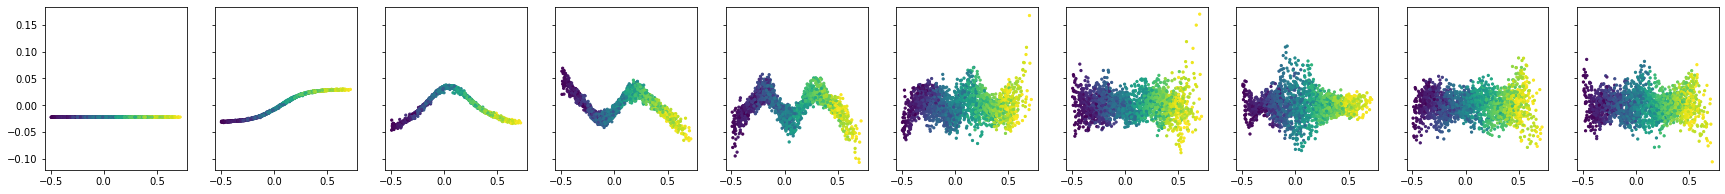

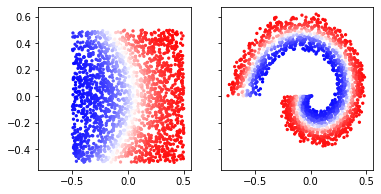

In [9]:
n_plots = 10
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*3,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(peff[idx_plot,].ravel(), jsf.jointly_smooth_functions[idx_plot,k],c=xyz[idx_plot,0], s=5)

fig,ax=plt.subplots(1,2,figsize=(6,3),sharey=True, sharex=True)
ax[0].scatter(*s1[idx_plot,:].T,c=jsf.jointly_smooth_functions[idx_plot,1], s=m_s, cmap=cmap2);
ax[1].scatter(*s2[idx_plot,:].T,c=jsf.jointly_smooth_functions[idx_plot,1], s=m_s, cmap=cmap2);

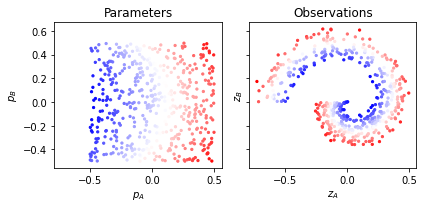

In [10]:
n_new_pts = 500
idx_plot_new = np.arange(0, n_new_pts)
random_seed = 5
rng = np.random.default_rng(random_seed)

xyz_new = rng.uniform(low=-.5,high=.5,size=(n_new_pts,3))
x_new, y_new, z_new = xyz_new[:,0].reshape(-1,1), xyz_new[:,1].reshape(-1,1), xyz_new[:,2].reshape(-1,1)


s1_new = sensor1(x_new,y_new,3,3)

omega_new = z_new[:,0]
peff_new = s1_new[:,0]+1*s1_new[:,1]**2

s2_new = sensor2(peff_new,z_new[:,0],2,2)


fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

ax[0].scatter(*s1_new[:,[0,1]][idx_plot_new,:].T, s=m_s,c=peff_new[idx_plot_new,], cmap=cmap2)
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

ax[1].scatter(*s2_new[idx_plot_new,:].T, s=m_s,c=peff_new[idx_plot_new,], cmap=cmap2)
ax[1].set_title("Observations");
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()

In [11]:
result = jsf.transform(np.column_stack([s1_new, s2_new]))

/home/ludwig/code/Python/spectral-discovery-of-jointly-smooth-features-for-multimodal-data/python/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/ludwig/code/Python/spectral-discovery-of-jointly-smooth-features-for-multimodal-data/python/venv/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


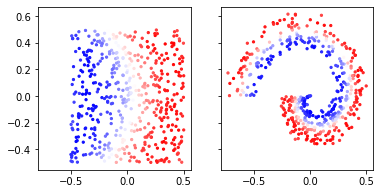

In [12]:
fig,ax=plt.subplots(1,2,figsize=(6,3),sharey=True, sharex=True)
ax[0].scatter(*s1_new[idx_plot_new,:].T,c=result[idx_plot_new, 1], s=m_s, cmap=cmap2);
ax[1].scatter(*s2_new[idx_plot_new,:].T,c=result[idx_plot_new, 1], s=m_s, cmap=cmap2);